# Halpha Emitters S-PLUS

In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from itertools import combinations
import umap
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

/home/luis/anaconda3/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/luis/anaconda3/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/luis/anaconda3/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

In [2]:
# Open the CSV files
# Define the pattern to match CSV files
pattern = '../Ha-emitters/*PerField_wise.csv'

# Use glob to find all CSV files in the current directory
csv_files = glob.glob(pattern)

# Create an empty list to store DataFrames
dfs = []

In [3]:
# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

In [4]:
# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,0000,0,87nn,AACU,182.0,57.0,64.0,59.0,0.115,0.129107
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,0000,1,99nn,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,hh00,0,99nn,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,0000,0,98nn,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,0000,0,01nn,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,b'STRIPE82-0157',b'iDR4_3_STRIPE82-0157_0016873',349.808612,-0.962720,7268.3916,3780.7950,0.000391,1.049551,8.169368e-07,3.894912,...,0000,0,0nnn,ABUU,-127.0,811.0,-1330.0,808.0,NaN,0.073261
3196,b'STRIPE82-0158',b'iDR4_3_STRIPE82-0158_0009177',350.254869,0.323001,4347.6445,3032.8470,0.000335,0.986151,6.768905e-07,4.712428,...,0000,0,11nn,AABC,86.0,287.0,-678.0,293.0,NaN,0.122334
3197,b'STRIPE82-0162',b'iDR4_3_STRIPE82-0162_0018498',352.418578,0.670626,8739.1020,5308.4004,0.000349,1.035019,6.068673e-07,3.826304,...,0000,0,0nnn,ABUU,475.0,471.0,141.0,482.0,0.700,0.797824
3198,b'STRIPE82-0163',b'iDR4_3_STRIPE82-0163_0014886',354.578466,-0.927664,3879.0051,4010.2715,0.000404,1.171372,4.901620e-07,4.799046,...,0000,0,0nnn,ABUU,451.0,891.0,-856.0,897.0,NaN,0.562681


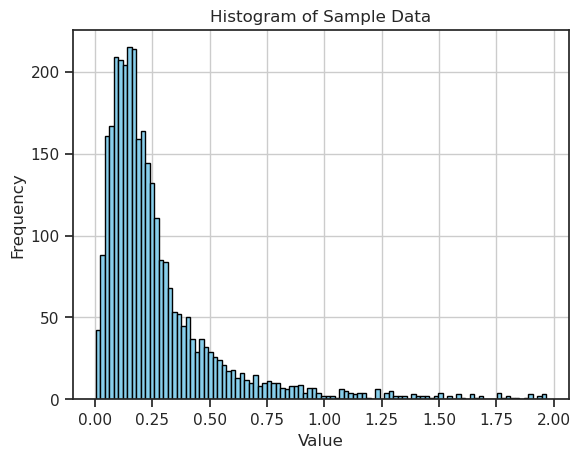

In [5]:
# See the distance of the SPLUS nad WISE source
# Plotting the histogram
plt.hist(combined_df["angDist"], bins=100, color='skyblue', edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Sample Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability
plt.show()



In [6]:
for columns in combined_df.columns:
    print(columns)

Field
ID
RA
DEC
X
Y
FWHM
FWHM_n
ISOarea
KRON_RADIUS
MU_MAX_INST
PETRO_RADIUS
SEX_FLAGS_DET
SEX_NUMBER_DET
CLASS_STAR
s2n_DET_PStotal
THETA
ELLIPTICITY
ELONGATION
FLUX_RADIUS_20
FLUX_RADIUS_50
FLUX_RADIUS_70
FLUX_RADIUS_90
s2n_r_PStotal
s2n_J0660_PStotal
s2n_i_PStotal
FWHM_r
FWHM_n_r
FWHM_J0660
FWHM_n_J0660
FWHM_i
FWHM_n_i
SEX_FLAGS_r
SEX_FLAGS_J0660
SEX_FLAGS_i
CLASS_STAR_r
CLASS_STAR_J0660
CLASS_STAR_i
r_PStotal
e_r_PStotal
g_PStotal
e_g_PStotal
i_PStotal
e_i_PStotal
u_PStotal
e_u_PStotal
z_PStotal
e_z_PStotal
J0378_PStotal
e_J0378_PStotal
J0395_PStotal
e_J0395_PStotal
J0410_PStotal
e_J0410_PStotal
J0430_PStotal
e_J0430_PStotal
J0515_PStotal
e_J0515_PStotal
J0660_PStotal
e_J0660_PStotal
J0861_PStotal
e_J0861_PStotal
r_psf
e_r_psf
g_psf
e_g_psf
i_psf
e_i_psf
u_psf
e_u_psf
z_psf
e_z_psf
J0378_psf
e_J0378_psf
J0395_psf
e_J0395_psf
J0410_psf
e_J0410_psf
J0430_psf
e_J0430_psf
J0515_psf
e_J0515_psf
J0660_psf
e_J0660_psf
J0861_psf
e_J0861_psf
AllWISE
RAJ2000
DEJ2000
eeMaj
eeMin
eePA
W1mag
W2

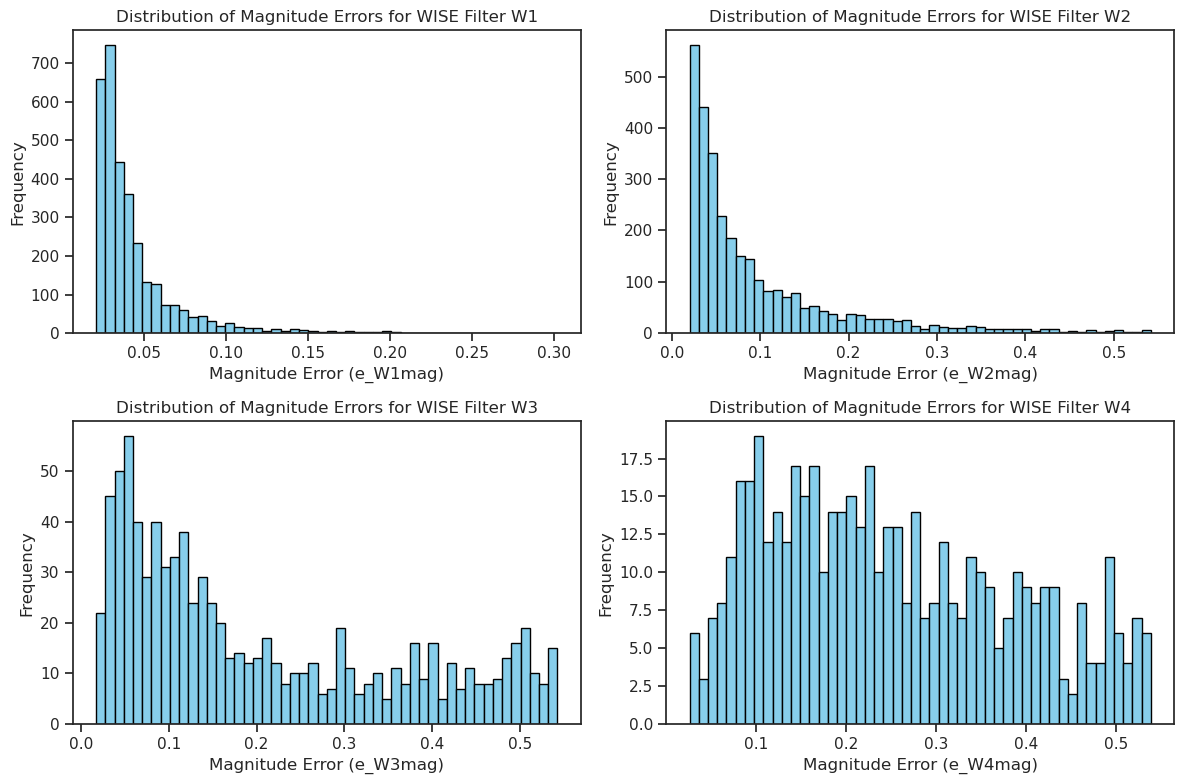

In [7]:
# Extract magnitude errors for WISE filters W1, W2, W3, W4
magnitude_errors_w1 = combined_df["e_W1mag"]
magnitude_errors_w2 = combined_df["e_W2mag"]
magnitude_errors_w3 = combined_df["e_W3mag"]
magnitude_errors_w4 = combined_df["e_W4mag"]

# Create subplots for each histogram
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for e_W1mag
axs[0, 0].hist(magnitude_errors_w1, bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of Magnitude Errors for WISE Filter W1')
axs[0, 0].set_xlabel('Magnitude Error (e_W1mag)')
axs[0, 0].set_ylabel('Frequency')

# Plot histogram for e_W2mag
axs[0, 1].hist(magnitude_errors_w2, bins=50, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of Magnitude Errors for WISE Filter W2')
axs[0, 1].set_xlabel('Magnitude Error (e_W2mag)')
axs[0, 1].set_ylabel('Frequency')

# Plot histogram for e_W3mag
axs[1, 0].hist(magnitude_errors_w3, bins=50, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of Magnitude Errors for WISE Filter W3')
axs[1, 0].set_xlabel('Magnitude Error (e_W3mag)')
axs[1, 0].set_ylabel('Frequency')

# Plot histogram for e_W4mag
axs[1, 1].hist(magnitude_errors_w4, bins=50, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Distribution of Magnitude Errors for WISE Filter W4')
axs[1, 1].set_xlabel('Magnitude Error (e_W4mag)')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [8]:
# Cleaned error

m_err_splus = (combined_df["e_r_PStotal"] <= 0.2) & (combined_df["e_g_PStotal"] <= 0.2) & \
        (combined_df["e_i_PStotal"] <= 0.2) & (combined_df["e_u_PStotal"] <= 0.2) & \
        (combined_df["e_J0378_PStotal"] <= 0.2) & (combined_df["e_J0395_PStotal"] <= 0.2) & \
        (combined_df["e_J0410_PStotal"] <= 0.2) & (combined_df["e_J0430_PStotal"] <= 0.2) & \
        (combined_df["e_J0515_PStotal"] <= 0.2) & (combined_df["e_J0660_PStotal"] <= 0.2) & \
        (combined_df["e_J0861_PStotal"] <= 0.2) & (combined_df["e_z_PStotal"] <= 0.2) 

# Choose a threshold for the maximum allowed magnitude error
max_allowed_e_Wmag = 0.5  # Example threshold value

# Apply the threshold to filter the dataset

m_err_wise = (combined_df["e_W1mag"] <= max_allowed_e_Wmag) & (combined_df["e_W2mag"] <= max_allowed_e_Wmag) 
        

mask_total = (m_err_splus & m_err_wise)

In [9]:
df_cleanErr = combined_df[mask_total]
len(df_cleanErr)

1930

In [10]:
#Selecting columns
columns = ["r_PStotal",
"g_PStotal",
"i_PStotal",
"u_PStotal",
"z_PStotal",
"J0378_PStotal",
"J0395_PStotal",
"J0410_PStotal",
"J0430_PStotal",
"J0515_PStotal",
"J0660_PStotal",
"J0861_PStotal"]

In [11]:
df_mag = df_cleanErr[columns]
df_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,14.816056,14.486720
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,12.990587,12.979302
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,14.003431,13.810323
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,14.518179,14.313604
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,15.035774,15.058778
...,...,...,...,...,...,...,...,...,...,...,...,...
3183,18.613853,18.923706,18.582360,19.189054,18.201460,18.717813,19.045317,18.990812,18.943542,18.894592,18.374134,18.431206
3186,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,18.828121,19.304344
3190,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,18.536316,18.690256
3192,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,18.574770,18.961899


### Creating the colors 

In [12]:
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

66

In [13]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [14]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/home/luis/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [15]:
df_colors_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,18.613853,18.923706,18.582360,19.189054,18.201460,18.717813,19.045317,18.990812,18.943542,18.894592,...,0.047270,0.096220,0.616678,0.559606,0.048950,0.569408,0.512336,0.520458,0.463386,-0.057072
3186,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
3190,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
3192,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129


In [16]:
# Drop magniytudes
df_colors = df_colors_mag.drop(columns=columns)

In [17]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,-0.309853,0.031493,-0.575201,0.412393,-0.103960,-0.431464,-0.376959,-0.329689,-0.280739,0.239719,...,0.047270,0.096220,0.616678,0.559606,0.048950,0.569408,0.512336,0.520458,0.463386,-0.057072
3186,-0.385913,0.021193,-0.400243,-0.121358,-0.244292,-0.337652,-0.389431,-0.369268,-0.392612,0.355147,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
3190,-0.450952,0.119095,-0.429224,0.151297,-0.388830,-0.413261,-0.618225,-0.593130,-0.363956,0.350918,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
3192,-0.534901,-0.015257,-1.513470,-0.119953,-1.412008,-0.814728,-0.914442,-1.044880,-0.356613,0.268484,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129


***Making the color using some WISE filters***

In [18]:
# Calculate differences between W1 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W1_{col}'] = df_cleanErr["W1mag"] - df_cleanErr[col]

# Calculate differences between W2 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W2_{col}'] = df_cleanErr["W2mag"] - df_cleanErr[col]


In [19]:
# Calculate difference between W1 and W2
df_colors['diff_W1_W2'] = df_cleanErr['W1mag'] - df_cleanErr['W2mag']

In [20]:
for columns in df_colors.columns:
    print(columns)

r_PStotal - g_PStotal
r_PStotal - i_PStotal
r_PStotal - u_PStotal
r_PStotal - z_PStotal
r_PStotal - J0378_PStotal
r_PStotal - J0395_PStotal
r_PStotal - J0410_PStotal
r_PStotal - J0430_PStotal
r_PStotal - J0515_PStotal
r_PStotal - J0660_PStotal
r_PStotal - J0861_PStotal
g_PStotal - i_PStotal
g_PStotal - u_PStotal
g_PStotal - z_PStotal
g_PStotal - J0378_PStotal
g_PStotal - J0395_PStotal
g_PStotal - J0410_PStotal
g_PStotal - J0430_PStotal
g_PStotal - J0515_PStotal
g_PStotal - J0660_PStotal
g_PStotal - J0861_PStotal
i_PStotal - u_PStotal
i_PStotal - z_PStotal
i_PStotal - J0378_PStotal
i_PStotal - J0395_PStotal
i_PStotal - J0410_PStotal
i_PStotal - J0430_PStotal
i_PStotal - J0515_PStotal
i_PStotal - J0660_PStotal
i_PStotal - J0861_PStotal
u_PStotal - z_PStotal
u_PStotal - J0378_PStotal
u_PStotal - J0395_PStotal
u_PStotal - J0410_PStotal
u_PStotal - J0430_PStotal
u_PStotal - J0515_PStotal
u_PStotal - J0660_PStotal
u_PStotal - J0861_PStotal
z_PStotal - J0378_PStotal
z_PStotal - J0395_PStotal


# Reduction dimensionality

## UMAP 

Given that there are 66 variables, we use UMAP. I think UMAP is the best option because these variables are probably not linearly correlated. [UMAP](https://umap-learn.readthedocs.io/en/latest/) (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces. If you have 66 variables and suspect they are not linearly correlated, UMAP could be a suitable method for exploring the structure of your data in a lower-dimensional space while preserving non-linear relationships. However, the effectiveness of UMAP depends on various factors, including the nature of your data and the specific goals of your analysis. It's always a good idea to experiment with different techniques and evaluate their performance based on your data and objectives.

In [21]:
# Standarized the data
X_stand = StandardScaler().fit_transform(df_colors)

#### Try cross-validation 

To perform cross-validation for choosing the optimal number of components in UMAP.

In [22]:
# Split data into training and validation sets
X_train, X_val = train_test_split(X_stand, test_size=0.2, random_state=42)

In [23]:
# Define a range of number of components to try
num_components_range = [2, 3, 4, 5, 10, 20, 50]
n_neighbors_range = [5, 10, 20, 50, 100]

best_num_components = None
best_n_neighbors = None
best_silhouette_score = -1  # Initialize with a low value

In [24]:
# Loop over different numbers of components and neighbors
for num_components in num_components_range:
    for n_neighbors in n_neighbors_range:
        # Fit UMAP model
        reducer_ = umap.UMAP(n_neighbors=n_neighbors, n_components=num_components, random_state=42)
        X_train_trans = reducer_.fit_transform(X_train)

        # Cluster the transformed data using KMeans
        kmeans = KMeans(n_clusters=num_components, random_state=42)
        labels = kmeans.fit_predict(X_train_trans)

        # Evaluate performance on validation set using Silhouette Score
        silhouette = silhouette_score(X_train_trans, labels, random_state=42)
        print(f"Number of components: {num_components}, Number of neighbors: {n_neighbors}, Silhouette Score: {silhouette}")

        # Update best parameters if necessary
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_num_components = num_components
            best_n_neighbors = n_neighbors
            best_labels = labels

/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 2, Number of neighbors: 5, Silhouette Score: 0.5258592367172241


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 2, Number of neighbors: 10, Silhouette Score: 0.6729689836502075


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 2, Number of neighbors: 20, Silhouette Score: 0.7212724685668945


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 2, Number of neighbors: 50, Silhouette Score: 0.803726851940155


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 2, Number of neighbors: 100, Silhouette Score: 0.8345561623573303


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 3, Number of neighbors: 5, Silhouette Score: 0.5429242253303528


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 3, Number of neighbors: 10, Silhouette Score: 0.5676642656326294


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 3, Number of neighbors: 20, Silhouette Score: 0.7631446719169617


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 3, Number of neighbors: 50, Silhouette Score: 0.6124889254570007


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 3, Number of neighbors: 100, Silhouette Score: 0.6376937627792358


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 4, Number of neighbors: 5, Silhouette Score: 0.5999917387962341


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 4, Number of neighbors: 10, Silhouette Score: 0.5945072770118713


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 4, Number of neighbors: 20, Silhouette Score: 0.5281306505203247


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 4, Number of neighbors: 50, Silhouette Score: 0.5471993684768677


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 4, Number of neighbors: 100, Silhouette Score: 0.5700154900550842


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 5, Number of neighbors: 5, Silhouette Score: 0.49292024970054626


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 5, Number of neighbors: 10, Silhouette Score: 0.5168488025665283


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 5, Number of neighbors: 20, Silhouette Score: 0.5101298689842224


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 5, Number of neighbors: 50, Silhouette Score: 0.5448935031890869


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 5, Number of neighbors: 100, Silhouette Score: 0.5527478456497192


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 10, Number of neighbors: 5, Silhouette Score: 0.4901810884475708


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 10, Number of neighbors: 10, Silhouette Score: 0.5278704762458801


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 10, Number of neighbors: 20, Silhouette Score: 0.5138835906982422


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 10, Number of neighbors: 50, Silhouette Score: 0.49103233218193054


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 10, Number of neighbors: 100, Silhouette Score: 0.4881199598312378


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 20, Number of neighbors: 5, Silhouette Score: 0.49599114060401917


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 20, Number of neighbors: 10, Silhouette Score: 0.4748380482196808


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 20, Number of neighbors: 20, Silhouette Score: 0.46990665793418884


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 20, Number of neighbors: 50, Silhouette Score: 0.45374661684036255


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 20, Number of neighbors: 100, Silhouette Score: 0.43452057242393494


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 50, Number of neighbors: 5, Silhouette Score: 0.46829238533973694


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 50, Number of neighbors: 10, Silhouette Score: 0.4611443281173706


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 50, Number of neighbors: 20, Silhouette Score: 0.4298139214515686


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 50, Number of neighbors: 50, Silhouette Score: 0.40028730034828186


/home/luis/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 50, Number of neighbors: 100, Silhouette Score: 0.3839627504348755


In [25]:
# Output best parameters and corresponding silhouette score
print(f"Best number of components: {best_num_components}, Best number of neighbors: {best_n_neighbors}, Best Silhouette Score: {best_silhouette_score}")

Best number of components: 2, Best number of neighbors: 100, Best Silhouette Score: 0.8345561623573303


#### Try UMAP

In [26]:
num_components = 2
reducer = umap.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                    n_components=num_components,  # min_samples=15, min_cluster_size=60
                    random_state=42)
X_trans = reducer.fit_transform(X_stand)

Visualize the cumulative explained variance ratio:

In [27]:
# Calculate the variance of the original data points in the reduced space
original_variance = np.var(X_trans, axis=0)

# Calculate the explained variance ratio
explained_variance_ratio = original_variance / np.sum(original_variance)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

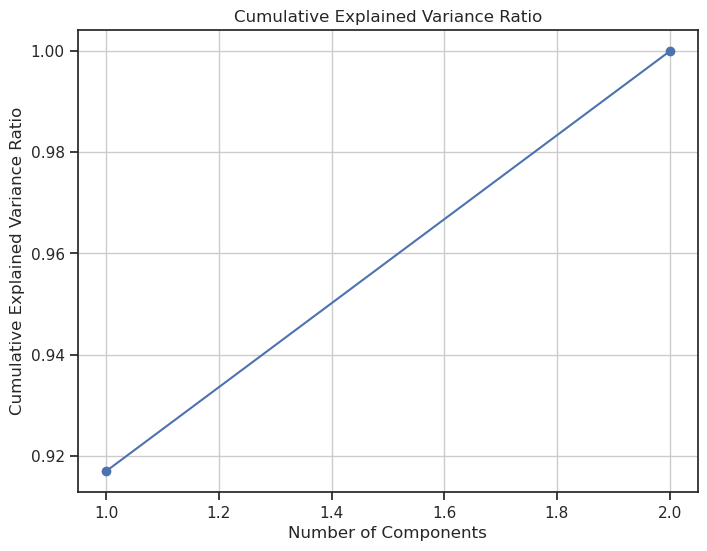

In [28]:
# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [29]:
#umap_df = pd.DataFrame(X_trans, columns = ["PC1", "PC2", "PC3"])
# Create a DataFrame for PCA results
umap_columns = [f'PC{i}' for i in range(1, num_components + 1)]
umap_df = pd.DataFrame(data=X_trans, columns=umap_columns)
umap_df

,PC1,PC2
0,12.407948,4.914541
1,6.950840,10.333717
2,11.000639,7.055591
3,12.101821,6.566817
4,8.090696,9.930400
...,...,...
1925,-2.818208,6.252802
1926,-4.269344,9.117775
1927,-3.604235,8.219595
1928,-4.231356,7.804427


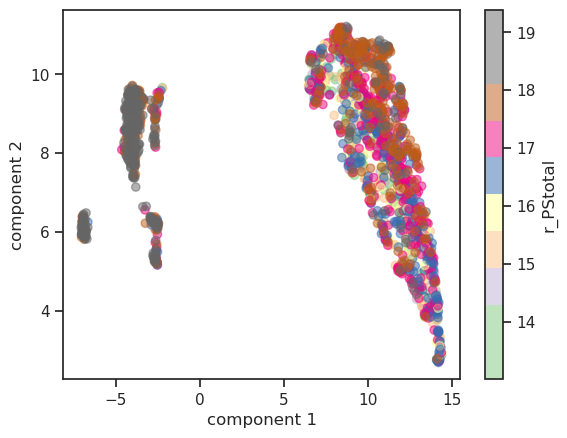

In [30]:
# Assuming umap_df is your DataFrame containing UMAP components and g_PStotal column
plt.scatter(umap_df["PC1"], umap_df["PC2"],
            c=df_cleanErr["r_PStotal"],  # Set color based on the values of "g_PStotal"
            alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='r_PStotal')  # Set the label of the color bar to 'g_PStotal'
plt.show()

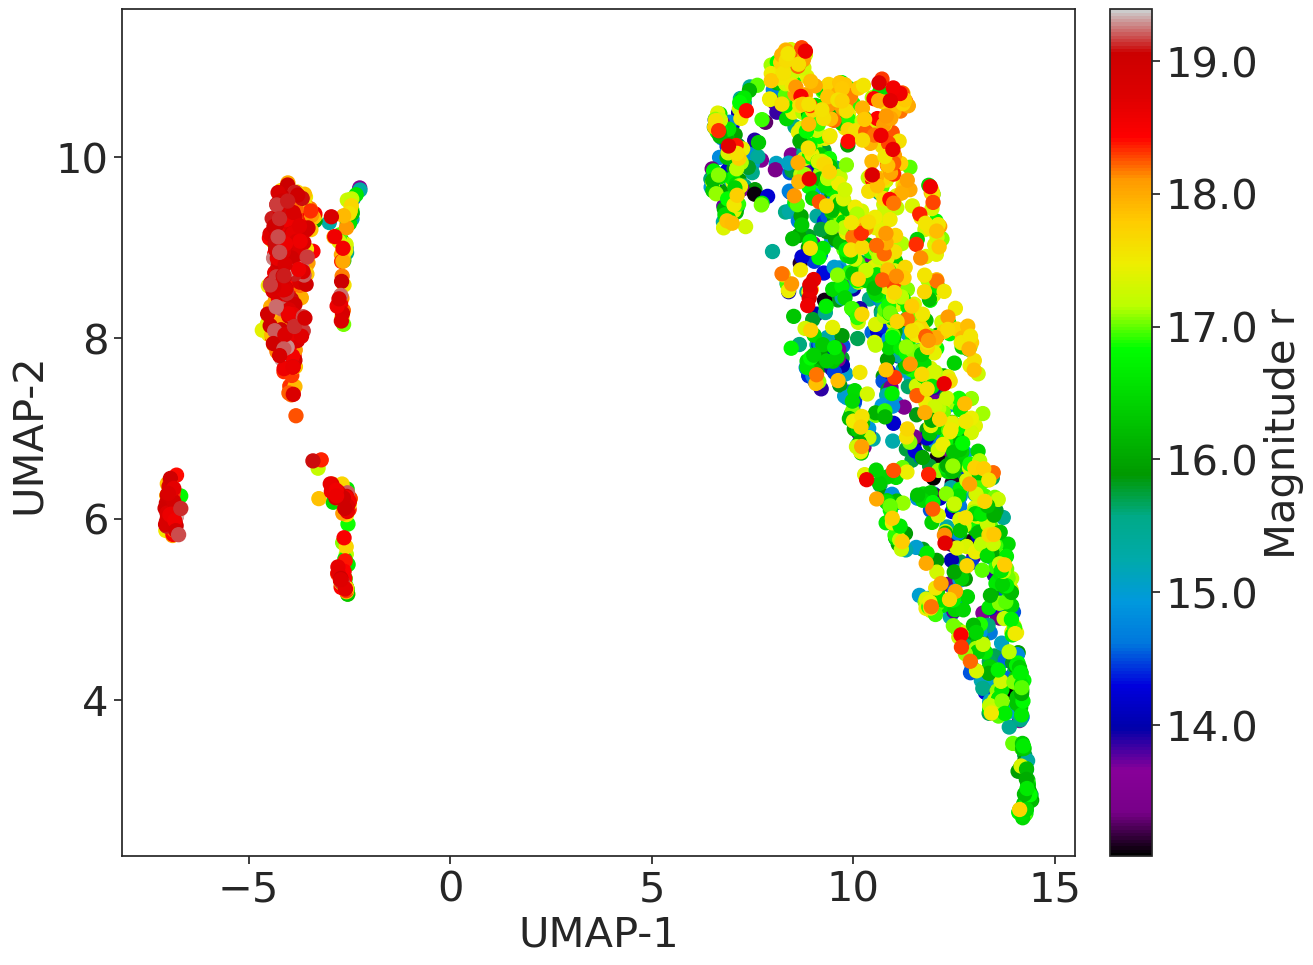

In [51]:
# Plotting
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(15, 11))
    plt.xlabel("UMAP-1", fontsize=30)
    plt.ylabel("UMAP-2", fontsize=30)
    plt.tick_params(axis='x', labelsize=30) 
    plt.tick_params(axis='y', labelsize=30)

    # Create a scatter plot
    sc = ax.scatter(umap_df["PC1"], umap_df["PC2"], c=df_cleanErr["r_PStotal"], cmap="nipy_spectral", s=100)
    
    # Add a colorbar with improved visibility
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, format='%.1f')
    cbar.set_label("Magnitude r", fontsize=30)  # Provide a label for the colorbar
    cbar.ax.tick_params(labelsize=30)  # Adjust the size of the tick labels

plt.savefig("../Figs/umap_splus_wise.pdf")

## HDBSCAN 

#### Find the best parameters 

To find the best min_samples and min_cluster_size parameters for HDBSCAN, you typically perform a grid search over a range of values and evaluate the clustering performance using a metric such as silhouette score or another relevant metric.

Here's a general approach you can follow:

    Define a grid of parameters to search over for min_samples and min_cluster_size.
    For each combination of parameters:
        Fit HDBSCAN to your data.
        Evaluate the clustering performance using a metric such as silhouette score.
    Select the parameters that result in the highest clustering performance according to your chosen metric.

Here's how you can perform this grid search:

In [31]:

# Define the range of values for min_samples and min_cluster_size
min_samples_range = [5, 10, 15, 20, 25, 30, 35]  # Adjust as needed
min_cluster_size_range = [40, 50, 60, 80, 100, 120, 150]  # Adjust as needed

In [32]:
best_score = -1
best_params = {}


In [33]:
for min_samples in min_samples_range:
    for min_cluster_size in min_cluster_size_range:
        # Fit HDBSCAN with the current parameters
        clusterer_ = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
        labels = clusterer_.fit_predict(X_trans)  # X is your data
        
        # Evaluate clustering performance using silhouette score
        silhouette_ = silhouette_score(X_trans, labels)
        
        # Check if current parameters result in a better silhouette score
        if silhouette_ > best_score:
            best_score = silhouette_
            best_params['min_samples'] = min_samples
            best_params['min_cluster_size'] = min_cluster_size

In [34]:
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

Best parameters: {'min_samples': 5, 'min_cluster_size': 100}
Best silhouette score: 0.7773979


### Applying HDBSCAN 

I foun that the best configurations of parameteres are 'min_samples': 5 and 'min_cluster_size': 100. We try then: 
But first try this min_samples=15, min_cluster_size=60

In [35]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=50, prediction_data=True, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=1, gen_min_span_tree=True)


In [36]:

clusterer.fit(X_trans)
labels = clusterer.labels_

In [37]:
clusterer.metric

'euclidean'

In [38]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_noise_ = list(labels).count(-1)


In [39]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of cluster points 0: 1440
Estimated number of cluster points 1: 63
Estimated number of cluster points 2: 98
Estimated number of cluster points 3: 52
Estimated number of noise points: 0


<AxesSubplot:>

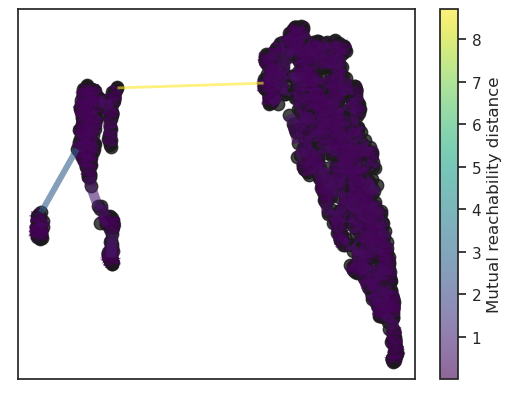

In [40]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)


### Build the cluster hierarchy 

<AxesSubplot:ylabel='distance'>

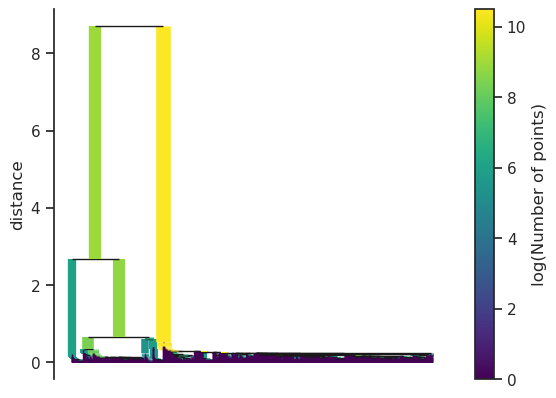

In [41]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Extract the clusters

<AxesSubplot:ylabel='$\\lambda$ value'>

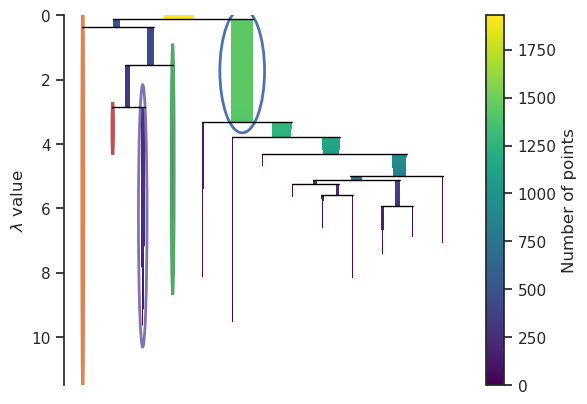

In [42]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Plting the components

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

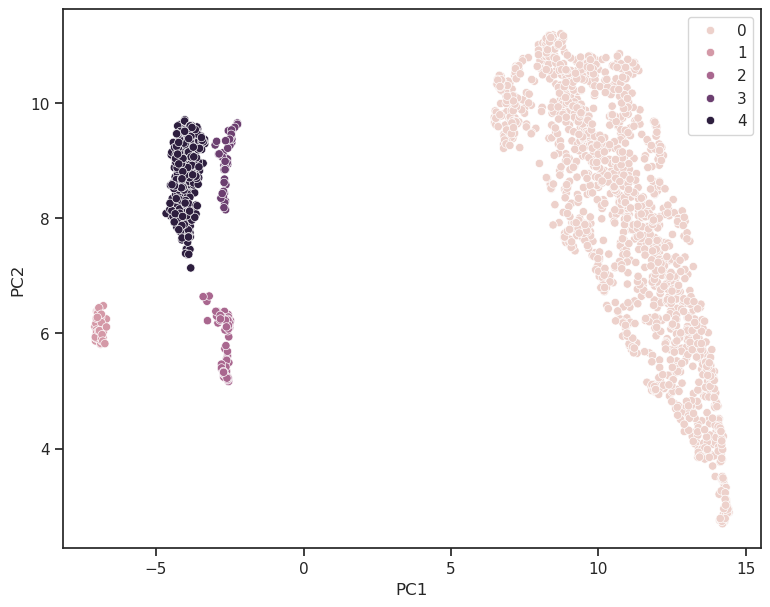

In [43]:
plt.figure(figsize=(9,7))
sns.scatterplot(x=umap_df["PC1"], y=umap_df["PC2"], 
                hue=labels,
                )

Create the tables for each clase

In [44]:
df_cleanErr["Label"] = labels

/tmp/ipykernel_336955/341984377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleanErr["Label"] = labels


In [45]:
df_cleanErr

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist,Label
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,0,87nn,AACU,182.0,57.0,64.0,59.0,0.115,0.129107,0
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,1,99nn,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308,0
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,0,99nn,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144,0
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,0,98nn,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241,0
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,0,01nn,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,b'STRIPE82-0132',b'iDR4_3_STRIPE82-0132_0011586',331.997487,0.289613,3249.1740,2814.3223,0.000363,1.000263,1.213735e-06,4.081015,...,0,000n,AAAB,94.0,170.0,-215.0,157.0,NaN,0.084062,2
3186,b'STRIPE82-0142',b'iDR4_3_STRIPE82-0142_0014029',339.139727,0.448016,2885.1482,3851.2144,0.000379,1.013615,6.535494e-07,4.638296,...,0,00nn,AABU,360.0,456.0,139.0,471.0,NaN,0.232709,4
3190,b'STRIPE82-0147',b'iDR4_3_STRIPE82-0147_0003349',343.495206,-1.289140,2208.1868,1643.8495,0.000305,0.945969,7.469136e-07,3.516137,...,0,00nn,AACU,404.0,820.0,-89.0,866.0,NaN,0.227701,4
3192,b'STRIPE82-0151',b'iDR4_3_STRIPE82-0151_0033785',346.434130,-0.425545,1524.9784,7296.7880,0.000348,0.984726,6.535494e-07,3.597043,...,0,000n,AAAB,-237.0,316.0,-142.0,323.0,NaN,0.150187,4


**Preliminary conlusions**\\
Wiht the parameters recomended by the Silhouette HDBSCAM fin two group, on which one corresponds to the EB. BUt using (min_samples=5, min_cluster_size=60 HDBCAM find four group one coressponds to to the EB, aother to CV and QSOS and AGN, and the other two to QSOS each one corresnp a specific redshift.

In [46]:
# Group the data based on the "Label" column
grouped_data = df_cleanErr.groupby("Label")

In [47]:
# Define the directory where you want to save the CSV files
directory = '../Class_allfilter_wise/'

In [48]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_wise_noise.csv'
    else:
        filename = f'Halpha_emitter_wise_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)